In [1]:
import os
os.environ["JAX_PLATFORM_NAME"] = "cpu"
import jax
import numpy as np

from sde4mbrlExamples.rotor_uav.sde_rotor_model import load_predictor_function, load_trajectory

%matplotlib widget
import matplotlib.pyplot as plt

# Magic IPython deepreloading...
%reload_ext autoreload
%autoreload 2
import builtins
from IPython.lib import deepreload
builtins.reload = deepreload.reload

%autoreload

2023-04-09 21:45:58.371764: E external/org_tensorflow/tensorflow/stream_executor/cuda/cuda_driver.cc:265] failed call to cuInit: CUDA_ERROR_UNKNOWN: unknown error


In [48]:
# Load some data to try the model on
# path_traj = '/home/franckdjeumou/Documents/log_flights/log_6_2022-10-25-14-03-16.ulg'
path_traj = '/home/franckdjeumou/Documents/log_flights/hexa_sitl_1.ulg'
# path_traj = '/home/franckdjeumou/Documents/PX4-Autopilot/build/px4_sitl_default/rootfs/log/2023-01-21/02_13_43.ulg'
_traj_x, _traj_u = load_trajectory(path_traj) # Only the first trajectory
traj_data = {'y' : _traj_x[0], 'u' : _traj_u[0]}
# traj_data = {'y' : _traj_x[0][:100*(_traj_x[0].shape[0]//100)], 'u' : _traj_u[0][:100*(_traj_u[0].shape[0]//100)]}
data_stepsize = 0.01
traj_time_evol = np.array([i*data_stepsize for i in range(traj_data['y'].shape[0])])

Mean time step: 0.010 s


  0%|          | 0/7715 [00:00<?, ?it/s]

  0%|          | 0/7715 [00:00<?, ?it/s]

  0%|          | 0/7715 [00:00<?, ?it/s]

  0%|          | 0/7715 [00:00<?, ?it/s]

The length of the sequence is 6747 | Original = 7715


In [47]:
# # Do a moving average of _traj_u
# window_size = 40
# # _traj_u = np.vstack([np.convolve(traj_data['u'][:, i], np.ones((window_size,))/window_size, mode='same') for i in range(traj_data['u'].shape[1])]).T
# _traj_u = traj_data['u']
# # _traj_u = np.array([np.mean(traj_data['u'][i:i+window_size], axis=0) for i in range(traj_data['u'].shape[0]-window_size)])
# # Let's plot the control inputs
# # There are 6 inputs
# fig, axs = plt.subplots(6, 1, sharex=True, figsize=(10, 16))
# for i in range(6):
#     axs[i].plot(traj_time_evol, _traj_u[:, i])
#     axs[i].set_ylabel('u{}'.format(i))
#     axs[i].grid()
# axs[-1].set_xlabel('Time (s)')

# plt.show()

In [50]:
# Path for the learned sde parameters
sde_path = '/home/franckdjeumou/Documents/sde4mbrl/sde4mbrlExamples/rotor_uav/hexa_sitl/my_models/hexa_sitl_sde.pkl'
modified_params = {'horizon' : 20, 'num_particles' : 50, 'stepsize': 0.05}
# Create the nominal dynamics model
_nominal_model, nom_times = load_predictor_function(sde_path, prior_dist=True, nonoise=True, modified_params= {**modified_params, 'num_particles' : 1}, return_time_steps=True)
nominal_model = jax.jit(_nominal_model)
# Create posterior model
_posterior_model, post_times = load_predictor_function(sde_path, prior_dist=False, modified_params= modified_params, return_time_steps=True)
posterior_model = jax.jit(_posterior_model)

In [51]:
def n_steps_analysis(xtraj, utraj, jit_sampling_fn, time_evol):
    """Compute the time evolution of the mean and variance of the SDE at each time step

    Args:
        xtraj (TYPE): The trajectory of the states
        utraj (TYPE): The trajectory of the inputs
        jit_sampling_fn (TYPE): The sampling function return an array of size (num_particles, horizon, state_dim)
        time_evol (TYPE): The time evolution of the sampling technique

    Returns:
        TYPE: The multi-sampled state evolution
        TYPE: The time step evolution for plotting
    """
    sampler_horizon = len(time_evol) - 1
    dt_sampler = time_evol[1] - time_evol[0]
    # Check if dt_sampler and data_stepsize are close enough
    if abs(dt_sampler - data_stepsize) < 1e-5:
        quot = 1
    else:
        assert dt_sampler > data_stepsize-1e-5, "The time step of the sampling function must be larger than the data step size"
        assert abs(dt_sampler % data_stepsize) <= 1e-6, "The time step of the sampling function must be a multiple of the data step size"
        quot = dt_sampler / data_stepsize

    # print(dt_sampler, data_stepsize, dt_sampler % sampler_horizon, sampler_horizon % dt_sampler)
    # assert dt_sampler > data_stepsize-1e-6, "The time step of the sampling function must be larger than the data step size"
    # assert abs(dt_sampler % data_stepsize) <= 1e-6, "The time step of the sampling function must be a multiple of the data step size"
    quot = dt_sampler / data_stepsize
    # Take the closest integer to quot
    num_steps2data  = int(quot + 0.5)
    # Compute the actual horizon for splitting the trajectories
    traj_horizon = num_steps2data * sampler_horizon
    # Split the trajectory into chunks of size num_steps2data
    total_traj_size = (xtraj.shape[0] // traj_horizon) * traj_horizon
    xevol = xtraj[:total_traj_size+1]
    uevol = utraj[:total_traj_size]
    uevol = uevol.reshape(-1, sampler_horizon, num_steps2data, uevol.shape[-1])
    xevol = xevol[::traj_horizon]
    # Reshape the time evolution
    m_tevol = traj_time_evol[:total_traj_size+1][::traj_horizon]
    print(xevol.shape)
    print(uevol.shape)
    # assert xevol.shape[0] == uevol.shape[0], "The number of trajectories must be the same for the states and inputs"
    # Initial random number generator
    rng = jax.random.PRNGKey(0)
    rng, s_rng = jax.random.split(rng)
    xres = []
    tres = []
    for i in range(uevol.shape[0]):
        rng, s_rng = jax.random.split(rng)
        _curr_u = np.mean(uevol[i], axis=-2)
        # _curr_u = uevol[i,:,0,:]
        _curr_x = xevol[i]
        _xpred = np.array(jit_sampling_fn(_curr_x, _curr_u, s_rng)) # (num_particles, horizon+1, state_dim)
        _tevol = m_tevol[i] + time_evol
        if i < xevol.shape[0]-1:
            _xpred = _xpred[:,:-1,:]
            _tevol = _tevol[:-1]
        xres.append(_xpred)
        tres.append(_tevol)
    # Merge the results along the horizon axis
    xres = np.concatenate(xres, axis=1)
    tres = np.concatenate(tres, axis=0)
    print(xres.shape, tres.shape)
    return xres, tres



In [ ]:
# COmpute trajectory by the nominal model
xevol_nominal, tnominal = n_steps_analysis(traj_data['y'], traj_data['u'], nominal_model, nom_times)

In [52]:
# COmpute trajectory by the nominal model
xevol_posterior, tposterior = n_steps_analysis(traj_data['y'], traj_data['u'], posterior_model, post_times)

(68, 13)
(67, 20, 5, 6)
(50, 1340, 13) (1340,)


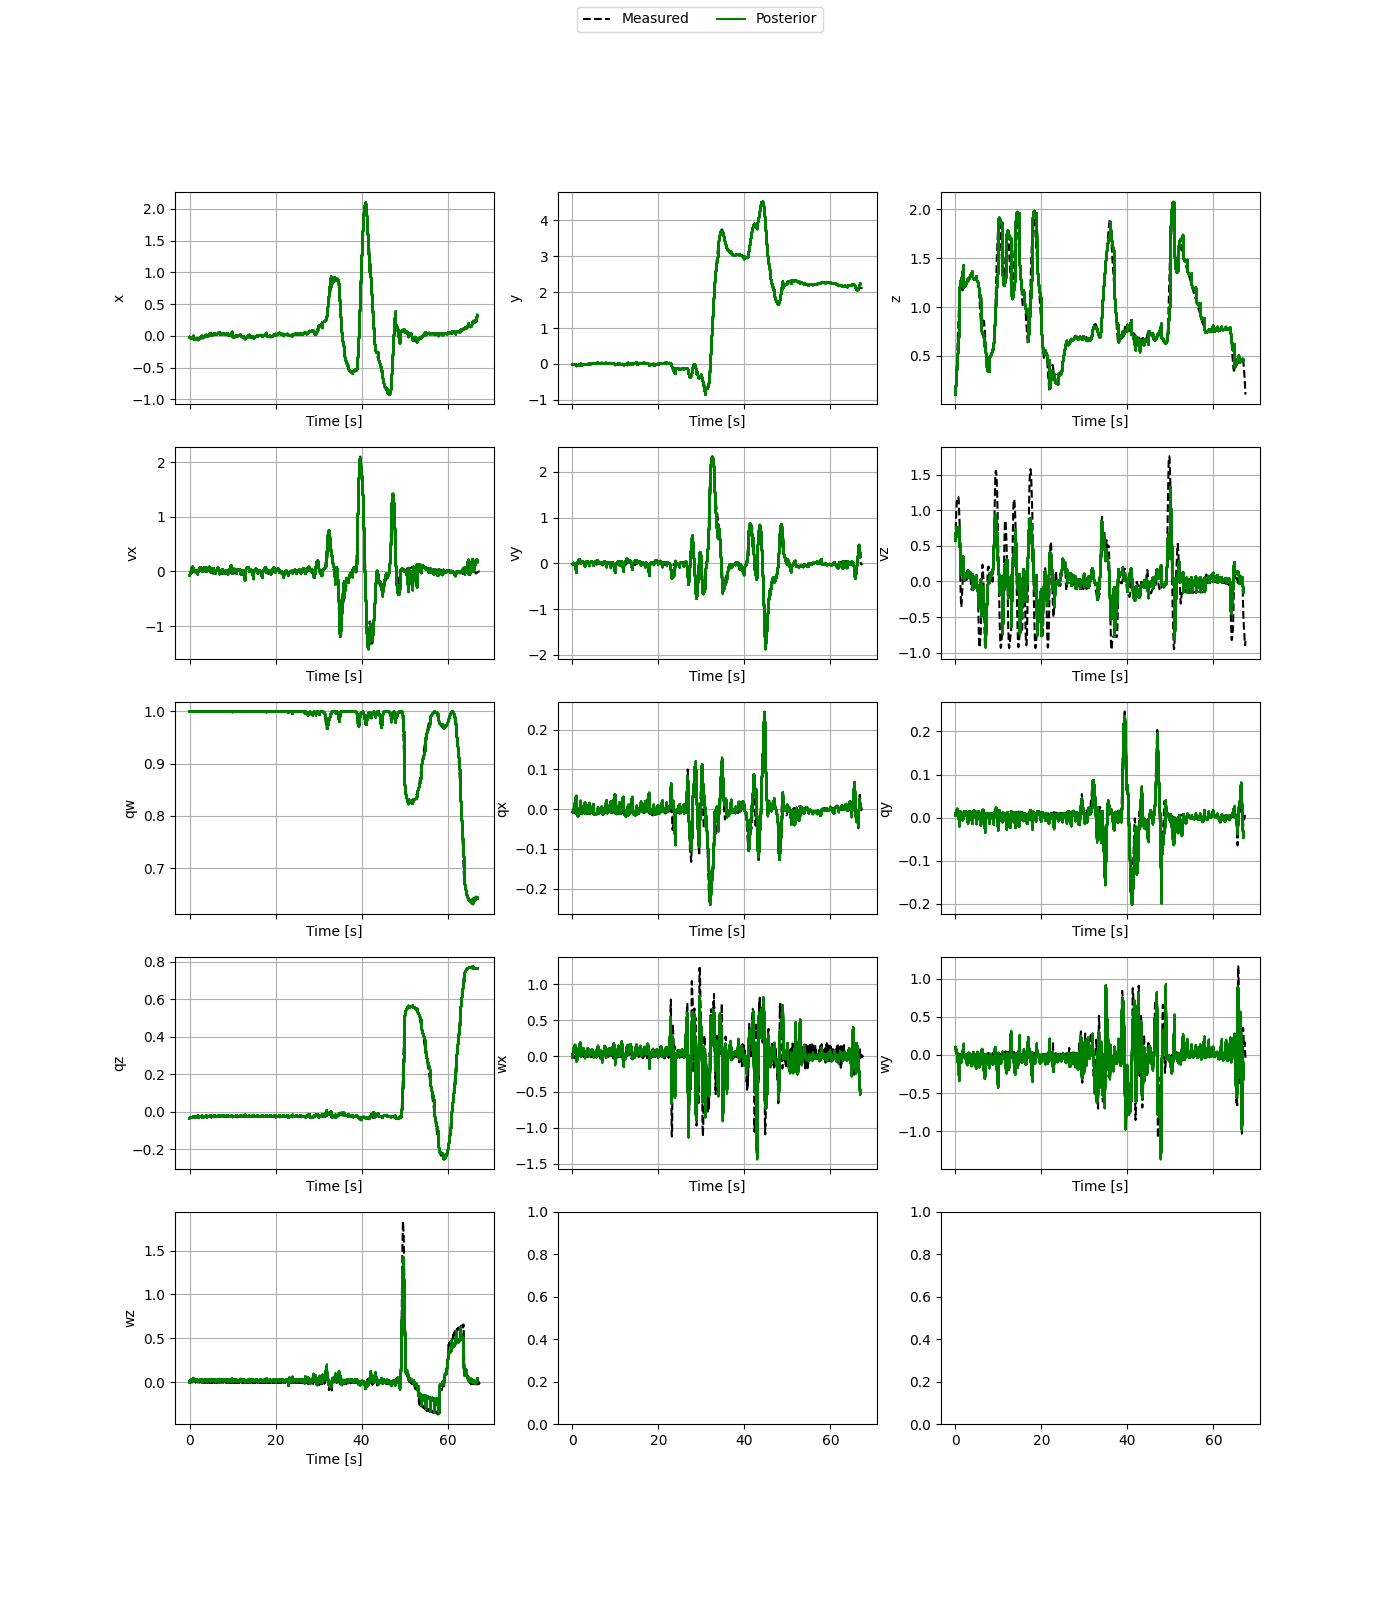

In [53]:
# The states in the x array
name_states = ['x', 'y', 'z', 'vx', 'vy', 'vz', 'qw', 'qx', 'qy', 'qz', 'wx', 'wy', 'wz']
fig, axs = plt.subplots(5,3, figsize=(14,16), sharex=True)
axs = axs.flatten()
for i in range(len(name_states)):
    # Let's plot the posterior xevol_posterior, tposterior
    axs[i].plot(traj_time_evol, traj_data['y'][:,i], color='k', linestyle='--', label='Measured')
    for k in range(xevol_posterior.shape[0]):
        axs[i].plot(tposterior, xevol_posterior[k,:,i], color='g', label='Posterior' if k==0 else None)
    # # Let's plot the nominal xevol_nominal, tnominal
    # for k in range(xevol_nominal.shape[0]):
    #     axs[i].plot(tnominal, xevol_nominal[k,:,i], color='r', label='Nominal' if k==0 else None)
    # # axs[i].plot(time_evol[:ash], xevol_prior[:,0,i], color='b', label='prior')
    # for k in range(num_sample_plot):
    #     min_size = min(time_evol.shape[0], xevol_posterior.shape[0])
    #     # axs[i].plot(time_evol[:ash], xevol_prior[:,k,i], color='b', label='prior' if k==0 else None)
    #     axs[i].plot(time_evol[:min_size], xevol_posterior[:min_size,k,i], color='g', label='Posterior' if k==0 else None)
    # # axs[i].plot(time_evol[:min_size], xevol_nominal[:min_size,0,i], color='r', label='Nominal')
    # axs[i].plot(time_evol, xtraj_true[:,i], color='k', linestyle='--', label='Measured')
    # axs[i].plot(xevol_prior[:,0,i], label='Prior')
    # axs[i].plot(xevol_posterior[:,0,i], label='Posterior')
    axs[i].set_ylabel(name_states[i])
    axs[i].set_xlabel('Time [s]')
    # axs[i].set_title(name_states[i])
    # axs[i].legend()
    axs[i].grid()

# Set a single legend for all subplots
handles, labels = axs[0].get_legend_handles_labels()
fig.legend(handles, labels, loc='upper center', ncol=5)